# Машинное обучение, ФКН ВШЭ

## Практическое задание 14. Оптимизация гиперпараметров.

### Общая информация

Дата выдачи: 04.06.2022

Мягкий дедлайн: 19.06.2022 23:59 MSK

Жёсткий дедлайн: 21.06.2022 23:59 MSK

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

- Ноутбук `homework-practice-14-Username.ipynb`
- Модули `distributions.py` и `optimizers.py`, содержащие написанный вами код

Username — ваша фамилия на латинице

### О задании

В этом задании вам предстоит разработать свой собственный AutoML фреймворк, который будет подбирать оптимальные значения гиперпараметров для определенной модели и обучающих данных. Попутно вы познакомитесь с основными концепциями Байесовской оптимизации и узнаете, как Гауссовские процессы и метод Парзеновского окна применяются на практике. Если вы все сделаете правильно, то на выходе получится фреймворк, не уступающий популярной `optuna`.

### Яндекс.Контест логин: ali.panesh

## 1. AutoML фреймворк (7.5 баллов)

Наш фреймворк будет работать по аналогии с классом [`OptunaSearchCV`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html#optuna.integration.OptunaSearchCV) из пакета `optuna`, который интегрирован с интерфейсом `sklearn`. Общая схема следующая: сначала мы выбираем модель, для которой будем подбирать гиперпараметры, и задаем распределения на них (решаем, будет ли параметр вещественным или целочисленным; определяем границы; выбираем линейную или логарифмическую шкалу). Далее, на каждой итерации мы выбираем новый набор значений гиперпараметров и оцениваем качество модели на них с помощью кросс-валидации. За ограниченное число итераций находим лучший набор гиперпараметров и обучаем итоговую модель на всех данных. Условимся, что мы хотим **максимизировать** значение метрики (в случае, если мы хотим минимизировать метрику, будем брать ее с минусом). Отличие между различными стратегиями поиска заключается в том, как именно выбираются новые значения гиперпараметров. Подробнее об этом ниже.

Вашу реализацию кода нужно будет протестировать через [ЯндексКонтест](https://contest.yandex.ru/contest/37803/). Помимо стандартных библиотек Python 3.7, в контесте доступны `numpy=1.21.6`, `scipy=1.7.3` и `scikit-learn=1.0.2`, а также их зависимости.

**Задание 1.1 (0.5 балла).** Реализуйте распределения гиперпараметров в файле `distributions.py`. Каждый класс должен поддерживать метод `sample`, который возвращает выборку из распределения. Кроме того, для численных распределений нам понадобится метод `scale`, который переводит выборку в промежуток $[0, 1]$ (с линейной шкалой) (за подробностями обращайтесь к док-строкам в базовых классах). Чуть позже станет понятнее, как нам пригодится эта функция. Задача в контесте: [ссылка](https://contest.yandex.ru/contest/37803/problems/A/).

**Задание 1.2 (1 балл).** Реализуйте методы `sample_params`, `cross_validate`, `fit`, `predict` и `predict_proba` класса `BaseOptimizer` в файле `optimizers.py`. Обратите внимание, что разбиение на фолды должно быть одинаковым для каждой итерации оптимизации (чтобы оценивать наборы гиперпараметров честно). Кроме того, не забывайте о воспроизводимости экспериментов: запуски всех алгоритмов, содержащих случайность, должны контролироваться с помощью `random_seed`. Также сохраняйте историю параметров и метрики в поля `self.params_history` и `self.scores_history`.

**Задание 1.3 (0.5 балла).** Реализуйте простейшую возможную стратегию &mdash; стратегию случайного поиска в классе `RandomSearchOptimizer` из файла `optimizers.py`. На каждой новой итерации алгоритма мы генерируем новый случайный набор гиперпараметров, не производя никакого дополнительного отбора. Задача в контесте: [ссылка](https://contest.yandex.ru/contest/37803/problems/B/)

### Байесовская оптимизация

Далее мы перейдем к более продвинутым методам поиска гиперпараметров. Одним из наиболее распространенных подходов к этой задаче является **Байейсовская оптимизация**. Ее суть состоит в следующем: на каждой итерации мы будем аппроксимировать распределение $p(y|x)$, где $y$ &mdash; это значение метрики, а $x$ &mdash; значение набора гиперпараметров. Допустим, что $y^*$ &mdash; это наилучшее (наибольшее) текущее значение метрики. Чтобы выбрать новое значение гиперпараметров, для которого мы будем учить модель, нам понадобится величина под названием **Expected Impovement (EI)**. Она определяется следующим образом:

$$
\text{EI}_{y^*}(x) = \mathbb{E}_{y \sim p(y|x)} \Big[\max(0, y - y^*)\Big] = \int \max(0, y - y^*) p(y|x) dy
$$

Соответственно, чем выше значение EI, тем большего увеличения $y^*$ мы ожидаем, обучив модель с гиперпараметрами $x$. Таким образом, на каждой итерации оптимизации мы будем семлировать несколько кандидатов $x_i, i=1, \dots, N$ из исходного распределения гиперпараметров и выбирать из них наилучшего путем максимизации EI: $x_{\text{new}} = \arg\max_{x_i} \big\{\text{EI}_{y^*} (x_i)\big\}$. Нам осталось обсудить, как именно аппроксимировать распределение $p(y|x)$.

### Гауссовские процессы

[Гауссовские процессы](https://en.wikipedia.org/wiki/Gaussian_process) (ГП) &mdash; одна из популярных опций для задания распределения $p(y|x)$. Если не вдаваться в глубокую теорию, то можно воспринимать ГП как случайные функции. ГП задаются двумя параметрами: функцией среднего $\mu(x)$ и ковариационной функцией $K(x, x')$. Процесс называется гауссовским, поскольку в каждой отдельно взятой точке $x$ мы имеем нормальное распределение: $y(x) \sim \mathcal{N}\big(\mu(x), K(x, x)\big)$. А условие $\text{Cov}\big(y(x), y(x')\big) = K(x, x')$ объясняет название ковариационной функции. Как правило, для практических применений достаточно так называемых стационарных ГП, которые отличают константная функция среднего $\mu(x)=\text{const}$ (чаще всего даже $\mu(x)=0$) и ковариационная функция, зависящая только от расстояния между точками: $K(x, x') = K\big(\|x-x'\|\big)$. Часто под переменной $x$ понимают время (отсюда название "процесс"), но мы будет рассматривать в качестве $x$ наше пространство гиперпараметров.

На первый взгляд может показаться, что ГП мало чем могут быть полезны: ведь в каждой точке $x$ у нас свое собственное случайное значение $y$. Но оказывается, что если ковариационная функция непрерывна в нуле, то (почти все) реализации ГП (то есть интересующие нас случайные значения $y(x)$) непрерывны. Таким образом, каждая реализация ГП соответствует некоторой непрерывной функции, а значит, ГП можно использовать для регрессии.

Если задана обучающая выборка $\{(x_i, y_i)\}_{i=1}^{\ell}$, то мы можем посчитать распределение $p(y|x) = \mathcal{N}\big(y\big|\mu(x), \sigma^2(x)\big)$ для любой точки $x$ (замечание: здесь уже не будет выполняться $\mu(x)=0$, так как распределение на $y$ апостериорное, то есть зависит от обучающих данных). При этом, для разных ковариационных функций мы будем получать разные распределения. Обычно в качестве ковариационных функций используют ядра (да-да, те самые из теоремы Мерсера). Нам повезло, что все это уже реализовано в классе [`sklearn.gaussian_process.GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor), и мы можем сконцентрироваться на алгоритмах оптимизации гиперпараметров.

Ниже приведен пример регрессии с помощью ГП:
![](https://www.researchgate.net/profile/Florent-Leclercq/publication/327613136/figure/fig1/AS:749406701776896@1555683889137/Illustration-of-Gaussian-process-regression-in-one-dimension-for-the-target-test.png)

Впрочем, в нашем случае, картинка будет выглядеть скорее так, поскольку $x$ будет многомерным:
![](https://raw.githubusercontent.com/jmaronas/TGP.pytorch/master/images/2D_GP.gif)

**Задание 1.4 (0.75 балла)**. Выведите аналитическую формулу для подсчета EI в случае $p(y|x) = \mathcal{N}\big(y\big|\mu(x), \sigma^2(x)\big)$ (подсказка: вам может пригодится значение функции распределения нормальной с.в.).

$$
\text{EI}_{y^*}(x) = \int \max(0, y - y^*) p(y|x) dy =
\frac{1}{\sigma \sqrt{2\pi}}\int_{y^*}^\infty (y - y^*) e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2} dy =\\
\frac{1}{\sigma \sqrt{2\pi}}\int_{y^*}^\infty (y - \mu) e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2} dy +
\frac{1}{\sigma \sqrt{2\pi}}\int_{y^*}^\infty (\mu - y^*) e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2} dy =
\Bigg[(e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2})' = -\frac{1}{\sigma^2}(y - \mu) e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2}\Bigg] =\\
-\frac{\sigma}{\sqrt{2\pi}}(-\frac{1}{\sigma^2}\int_{y^*}^\infty (y - \mu) e^{-\frac{1}{2}(\frac{y-\mu}{\sigma})^2} dy) +
(\mu - y^*) (1 - \Phi(y^* | \mu, \sigma)) =\\
\frac{\sigma}{\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{y^*-\mu}{\sigma})^2} + (\mu - y^*) (1 - \Phi(y^* | \mu, \sigma))
$$

Теперь разберемся, как адаптировать ГП под наши нужды. Предлагается следующий план действий:

1. Пускай на очередной итерации алгоритма $j$ у нас есть выборка $\{(x_i, y_i)\}_{i=1}^{j-1}$, где $x_i$ &mdash; значение набора гиперпараметров, а $y_i$ &mdash; соответствующее ему значение метрики, посчитанное по кросс-валидации.


2. Если размер выборки меньше значения `self.num_dry_runs`, то возвращаем случайное значение гиперпараметров вместо запуска алгоритма. Таким образом, первые `self.num_dry_runs` итераций поиска подчиняются случайной стратегии, чтобы "набрать статистику" для работы алгоритма.


3. ГП работает только с непрерывными величинами, поэтому давайте переведем значения гиперпараметров в диапазон $[0, 1]$ (тут-то нам и понадобится функция `scale`) и получим отнормированные гиперпараметры $x_i \to \tilde{x}_i$. Как вы догадываетесь, такой трюк сработает только с численными гиперпараметрами (как с непрерывными, так и с дискретными). Что делать с категориальными гиперпараметрами, обсудим позже. 


4. Далее обучаем ГП на выборку $\{(\tilde{x}_i, y_i)\}_{i=1}^{j-1}$ (в качестве ковариационной функции возьмите сумму константного, белого и RBF ядер). 


5. Семплируем кандидатов в новые значения гиперпараметров $x^{\text{new}}_1, ..., x^{\text{new}}_N$ и преобразуем их функцией `scale`. Для каждого набора предсказываем параметры распределения $\mu(\tilde{x}), \sigma^2(\tilde{x})$, затем вычисляем $\text{EI}_{y^*}(\tilde{x})$ по формуле, посчитанной вами выше, и выбираем набор гиперпараметров $\tilde{x}^\text{new}_{*}$ с наибольшим значением EI.


6. Выбираем исходный набор гиперпараметров $x^\text{new}_{*}$, соответствующий $\tilde{x}^\text{new}_{*}$. Вуаля! Мы получили новый набор численных гиперпараметров, на котором будем валидировать модель.


Для категориальных гиперпараметров попробуем провернуть что-нибудь похожее. Пусть у нас есть выборка $\{(f_i, y_i)\}_{i=1}^{j-1}$, где $f$ &mdash; интересующий нас категориальный гиперпараметр, $f_i \in \{1, \dots, C\}$ &mdash; конечное множество категорий. Зафиксируем $c \in \{1, \dots, C\}$ и рассмотрим $p(y|с) = \mathcal{N}\big(y\big|\mu(с), \sigma^2(с)\big)$. Определим параметры распределений следующим образом (как среднее и сглаженную дисперсию по категории):

$$
\mu(c) = \begin{cases}
    \cfrac{\sum_i [f_i = c] \cdot y_i}{\sum_i [f_i = c]},& \sum_i [f_i = c] > 0 \\
    y^*,& \sum_i [f_i = c] = 0
\end{cases}
\quad\quad\quad
\sigma^2(c) = \frac{1 + \sum_i [f_i = c] (y_i - \mu(c))^2}{1 + \sum_i [f_i = c]}
$$

В итоге, как и в случае с численными гиперпараметрами, мы находим категорию с лучшей EI. Впрочем, обычно такие гиперпараметры имеют не очень много возможных значений (скажем, не больше 10 категорий, а в реальности скорее 2-3: например, критерий при построении дерева), поэтому мы можем себе позволить **перебрать все значения** категориального признака **вместо семплирования** (что и требуется от вас в реализации). Обратите внимание, что категориальные гиперпараметры нужно обрабатывать отдельно (то есть они не имеют ничего общего с ГП, который мы обучаем по численным гиперпараметрам). Конечно, у такого подхода есть значительный минус: категории рассматриваются независимо друг от друга и от численных гиперпараметров, но уж лучше так, чем никак. 

**Задание 1.5 (2 балла)**. Реализуйте недостающие методы в классе `GPOptimizer` в файле `optimizers.py`. Задачи в контесте: [раз](https://contest.yandex.ru/contest/37803/problems/С/), [два](https://contest.yandex.ru/contest/37803/problems/D/)

### Tree-structured Parzen estimator (TPE)

Рассмотрим иной подход к приближению распределения $p(y|x)$. Он основан на использовании формулы Байеса:

$$
p(y|x) = \frac{p(x|y)p(y)}{p(x)}
$$

Эта формула позволяет нам моделировать распределение $p(x|y)$ вместо $p(y|x)$. Обозначим за $y^*$ $\gamma$-квантиль распределения $p(y)$, то есть $p(y < y^*)=\gamma$ (в отличие от ГП, где $y^*$ выступает как максимум распределения). Идея TPE заключается в следующем выражении для плотности $p(x|y)$:

$$
p(x|y) = \begin{cases}
    g(x),& y \ge y* \\
    l(x),& y < y^*,
\end{cases}
$$

где $l(x)$ &mdash; это аппроксимация распределения $x$ при значениях целевой метрики меньше порогового $y^*$, а $g(x)$ &mdash; наоборот, выше порогового. Оказывается, что такой способ задать распределение позволяет нам очень просто находить максимум EI:

**Задание 1.6 (0.75 балла)**. Докажите, что точка максимума EI совпадает с точкой максимума $\cfrac{g(x)}{l(x)}$.

$$
\text{EI}_{y^*}(x) = \int \max(0, y - y^*) p(y|x) dy =
\int_{y^*}^\infty (y - y^*) p(y|x) dy = 
\int_{y^*}^\infty (y - y^*) \frac{p(x|y)p(y)}{p(x)} dy = \\
\frac{1}{p(x)}
\int_{y^*}^\infty
(y - y^*) p(x|y)p(y) dy =
\frac{g(x)}{p(x)}
\int_{y^*}^\infty
(y - y^*) p(y) dy=
\frac{g(x)}{p(x)}
\cdot const
=\\
\frac{g(x)}{g(x)p(y \geq y^*) + l(x)p(y < y^*)}
\cdot const
=
\frac{1}{p(y \geq y^*) + p(y < y^*)\frac{l(x)}{g(x)}}
\cdot const
=
\frac{1}{(1-\gamma) + \gamma\frac{l(x)}{g(x)}}
\cdot const
$$

А это зависит только от $\frac{l(x)}{g(x)}$ причём EI больше там, где эта дробь меньше, а $\cfrac{g(x)}{l(x)}$ больше.

Таким образом, мы можем разделить все опробованные наборы гиперпараметров на две группы по значению целевой метрики, на каждой из них обучить свою оценку плотности ($g(x)$ или $l(x)$) и выбрать в качестве кандидата тот набор гиперпараметров, который имеет набольшее отношение плотностей. Такая процедура будет гарантировать нам максимизацию EI. В качестве алгоритма для приближения плотности мы будем пользоваться методом Парзеновского окна (он же Kernel Density Estimation, KDE), что и объясняет название оптимизатора (кстати, именно TPE находится под капотом у `optuna`). Как вы догадываетесь, KDE тоже реализован в [`sklearn.neighbors.KernelDensity`](https://www.youtube.com/watch?v=dQw4w9WgXcQ). И снова, такой подход позволяет обрабатывать только численные гиперпараметры. Получаем следующий алгоритм:

1. Пускай на очередной итерации алгоритма $j$ у нас есть выборка $\{(x_i, y_i)\}_{i=1}^{j-1}$, где $x_i$ &mdash; значение набора гиперпараметров, а $y_i$ &mdash; соответствующее ему значение метрики, посчитанное по кросс-валидации.


2. Если размер выборки меньше значения `self.num_dry_runs`, то возвращаем случайное значение гиперпараметров вместо запуска алгоритма.


3. Переводим значения гиперпараметров в диапазон $[0, 1]$ и получаем отнормированные гиперпараметры $x_i \to \tilde{x}_i$.


4. Считаем $\gamma$-квантиль выборки $y_1, \dots, y_{j-1}$ и делим значения гиперпараметров $\tilde{x}_1, \dots, \tilde{x}_{j-1}$ на две группы (воспользуйтесь `np.quantile`). 


5. На каждой группе обучаем KDE, чтобы получить оценки $g(\tilde{x})$ и $l(\tilde{x})$ (обратите внимание, что алгоритм возвращает логарифм оценки плотности). Используйте гауссовское ядро, в качестве параметра `bandwidth` возьмите медианное расстояние до 1-го ближайшего соседа в полной выборке. Остальные параметры оставьте по умолчанию.


6. Семплируем кандидатов в новые значения гиперпараметров $x^{\text{new}}_1, ..., x^{\text{new}}_N$ и преобразуем их функцией `scale`. Определяем точку:

$$
\tilde{x}^\text{new}_{*} = \arg\max_{i} \bigg\{\frac{g(\tilde{x}^{\text{new}}_i)}{l(\tilde{x}^{\text{new}}_i)}\bigg\}
$$


7. Выбираем исходный набор гиперпараметров $x^\text{new}_{*}$, соответствующий $\tilde{x}^\text{new}_{*}$.


Для категориальных гиперпараметров $f_i \in \{1, \dots, C\}$ нам тоже нужно определить $g(x)$ и $l(x)$. Определим вероятность категории $с \in \{1, \dots, C\}$ пропорциональной следующей величине:

$$
p(c) \propto N p_c + \sum_i [f_i = c], 
$$

где $N$ &mdash; число наборов гиперпараметров в группе (то есть это количество будет различным для $g(c)$ и $l(c)$), а $p_c$ &mdash; априорная вероятность категории (в нашем случае категории априорно равновероятны, $p_c = 1\,/\,C$). Сама вероятность $p(c)$ получается нормировкой по всем категориям гиперпараметра. И снова, мы будем **перебирать все значения** категориального признака **вместо семплирования**. Как и в случае ГП, категориальные гиперпараметры будут учитываться независимо от численных и друг от друга (тут даже можно выписать факторизацию распределения в виде $g(x) = g_{\text{num}}(x_\text{num}) \prod_{\text{cat}} g_{\text{cat}}(x_\text{cat})$, аналогично для $l(x)$, пусть эти формулы и не используются явно).

Выглядит итерация метода примерно так:

![](https://camo.githubusercontent.com/d14da729457267a66ebc9942b1ce57372adad287b74a1af5e0793f283c9bf1aa/687474703a2f2f6e657570792e636f6d2f5f696d616765732f7470652d73616d706c65642d63616e646964617465732e706e67)

**Задание 1.7 (2 балла)**. Реализуйте недостающие методы в классе `TPEOptimizer` в файле `optimizers.py`. Задачи в контесте: [раз](https://contest.yandex.ru/contest/37803/problems/E/), [два](https://contest.yandex.ru/contest/37803/problems/F/)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import distributions as D
import optimizers as O
import numpy as np
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

## 2. Эксперименты (7.5 баллов)

**Задание 2.1 (1 балл)**. Сгенерируйте случайную выборку наборов гиперпараметров и выборку значений метрик. Замерьте время работы метода `select_params` для `GPOptimizer` и `TPEOptimizer`. Постройте график зависимости времени работы от размера выборки, сделайте выводы. Какую алгоритмическую сложность имеют алгоритмы?

In [3]:
distr = {
    'alpha': D.UniformDistribution(0.1, 0.9),
    'alph': D.UniformDistribution(0.1, 0.9),
    'solve': D.CategoricalDistribution(['auto', 'svd', 'cholesky']),
    'solver': D.CategoricalDistribution(['auto', 'svd', 'cholesky']),
}

cnt_runs = 5

config_methods = {
    'TPE': {
        'method': O.TPEOptimizer,
        'time': [],
        'size': np.linspace(10, 1000, 20).astype(int),
    },
    'GP': {
        'method': O.GPOptimizer,
        'time': [],
        'size': np.linspace(10, 1000, 20).astype(int),
    }
}

for name_method, config_method in config_methods.items():
    for size in config_method['size']:
        total_time = 0.
        for cnt in range(cnt_runs):
            opt = config_method['method'](None, distr)
            opt.params_history = {
                'alpha': distr['alpha'].sample(size),
                'alph': distr['alph'].sample(size),
                'solve': distr['solve'].sample(size),
                'solver': distr['solver'].sample(size),
            }
            opt.scores_history = np.random.rand(size) * 20 - 5
            samples = opt.sample_params()
            start_time = time()
            opt.select_params(opt.params_history, opt.scores_history, samples)
            total_time += time() - start_time
        config_method['time'] += [total_time / cnt_runs]
clear_output()

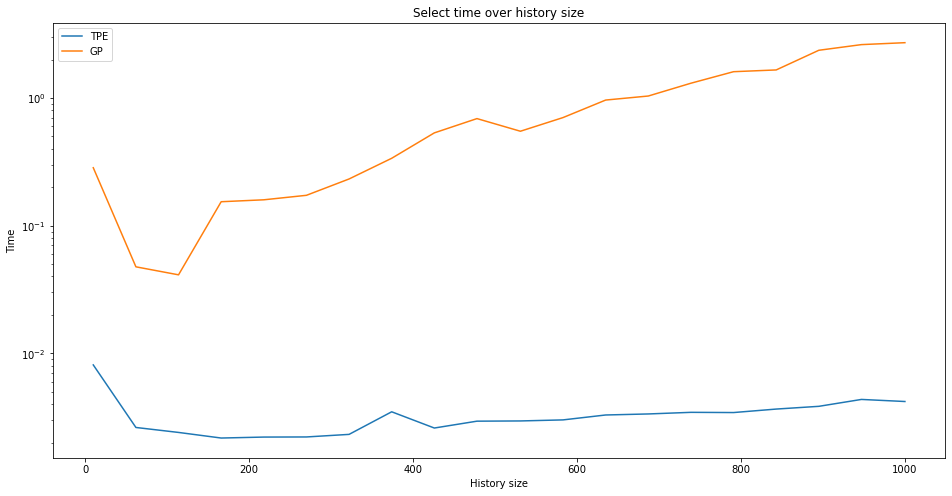

In [4]:
_, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.sca(ax)
for name_method, config_method in config_methods.items():
    plt.plot(config_method['size'], config_method['time'], label=name_method)
plt.title('Select time over history size')
plt.xlabel('History size')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

Дальнейшие эксперименты будет проводить на [наборе данных](https://www.kaggle.com/datasets/piyushagni5/white-wine-quality) о качестве белого вина.

**Задание 2.2 (3 балла)**. Будем тестировать оптимизаторы на (барабанная дробь...) бустингах. Выберите библиотеку градиентного бустинга, которая приходится вам по душе и задайте распределения на гиперпараметры. Среди ваших гиперпараметров обязательно должны быть число деревьев, глубина дерева и learning rate, также добавьте еще 4-5 гиперпараметров по вашему желанию (среди них должен быть хотя бы один категориальный). Подумайте, какие распределения лучше всего подходят для каждого гиперпараметра.

Как и всегда, разделите выборку на обучение и тест, предсказывать будем рейтинг вина (колонка `quality`). Хоть рейтинги и можно упорядочить, давайте решим задачу многоклассовой классификации на этих данных. В качестве метрики качества возьмем log loss. Мы будем сравнивать три стратегии для поиска, реализованные вами и [`OptunaSearchCV`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html#optuna.integration.OptunaSearchCV) из библиотеки `optuna`, который имеет такой же интерфейс. Давайте ограничим наш бюджет поиска 40 итерациями. Обучите каждый из этих четырех методов по нескольку раз, чтобы посмотреть на дисперсию метрики (как минимум 3 раза, а в идеале раз 5, если позволяет время).

Теперь попробуем визуализировать, что у нас получилось. Сделайте 4 сабплота, по одному на каждую стратегию поиска. На каждом графике изобразите лучшее найденное значение метрики, усредненное по запускам алгоритма, против номера итерации. Также нарисуйте область ± одного стандартного отклонения лучшего значения метрики. Кроме того, на том же графике сделайте scatter-plot **(номер итерации, значение метрики)** для этого запуска (именно для текущего набора гиперпараметра с итерации, а не лучшее, как для прошлого графика). Можете рисовать scatter-plot для всех повторных запусков сразу.

Прокомментируйте наблюдаемое. Какой(-ие) алгоритм(-ы) показали себя лучше всего? Какой(-ие) можно назвать более стабильным(-и)?

In [5]:
from optuna.integration import OptunaSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
import pandas as pd

df = pd.read_csv('winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [37]:
x = df.loc[:, df.columns != 'quality']
y = df['quality']

In [105]:
from optuna import distributions as OD

y_unique = y.unique()
def log_loss_est(estimator, X_test, y_test):
    return log_loss(y_test, estimator.predict_proba(X_test), labels=y_unique)

distributions = {
    'num_trees': D.IntUniformDistribution(1, 5),
    'depth': D.IntUniformDistribution(1, 16),
    'learning_rate': D.LogUniformDistribution(1e-5, 1),
    'l2_leaf_reg': D.UniformDistribution(0, 1e3),
    'rsm': D.UniformDistribution(0, 1),
    'feature_border_type': D.CategoricalDistribution([
        'Median', 'Uniform', 'UniformAndQuantiles',
        'GreedyLogSum', 'MaxLogSum', 'MinEntropy']),
    'fold_permutation_block': D.IntUniformDistribution(1, 256),
    'min_data_in_leaf': D.IntUniformDistribution(1, 20),
}

distributions_optuna = {
    'num_trees': OD.IntUniformDistribution(1, 5),
    'depth': OD.IntUniformDistribution(1, 16),
    'learning_rate': OD.LogUniformDistribution(1e-5, 1),
    'l2_leaf_reg': OD.UniformDistribution(0, 1e3),
    'rsm': OD.UniformDistribution(0, 1),
    'feature_border_type': OD.CategoricalDistribution([
        'Median', 'Uniform', 'UniformAndQuantiles',
        'GreedyLogSum', 'MaxLogSum', 'MinEntropy']),
    'fold_permutation_block': OD.IntUniformDistribution(1, 256),
    'min_data_in_leaf': OD.IntUniformDistribution(1, 20),
}

def config_fabric(method):
    return {
        'best_scores': [],
        'score_histories': [],
        'params_histories': [],
        'method': method,
        'fitted': None,
    }

config_results = {
    'Random': config_fabric(O.RandomSearchOptimizer),
    'GP': config_fabric(O.GPOptimizer),
    'TPE': config_fabric(O.TPEOptimizer),
    'Optuna': config_fabric(OptunaSearchCV)
}

for _ in range(1):
    for name_method, config_method in config_results.items():
        if name_method == 'Optuna':
            opt = config_method['method'](CatBoostClassifier(verbose=False), distributions_optuna, n_trials=3, scoring=log_loss_est, n_jobs=3)
        else:
            opt = config_method['method'](CatBoostClassifier(verbose=False), distributions, num_runs=3, scoring=log_loss_est, n_jobs=3)
        opt.fit(x, y)
        if name_method == 'Optuna':
            config_method['best_scores'] += [opt.best_score_]
            config_method['score_histories'] += [list(opt.trials_dataframe()['value'])]
            config_method['params_histories'] += [opt.trials_dataframe().to_dict()]
        else:
            config_method['best_scores'] += [opt.best_score]
            config_method['params_histories'] += [opt.params_history]
            config_method['score_histories'] += [list(opt.scores_history)]
        config_method['fitted'] = opt
clear_output()

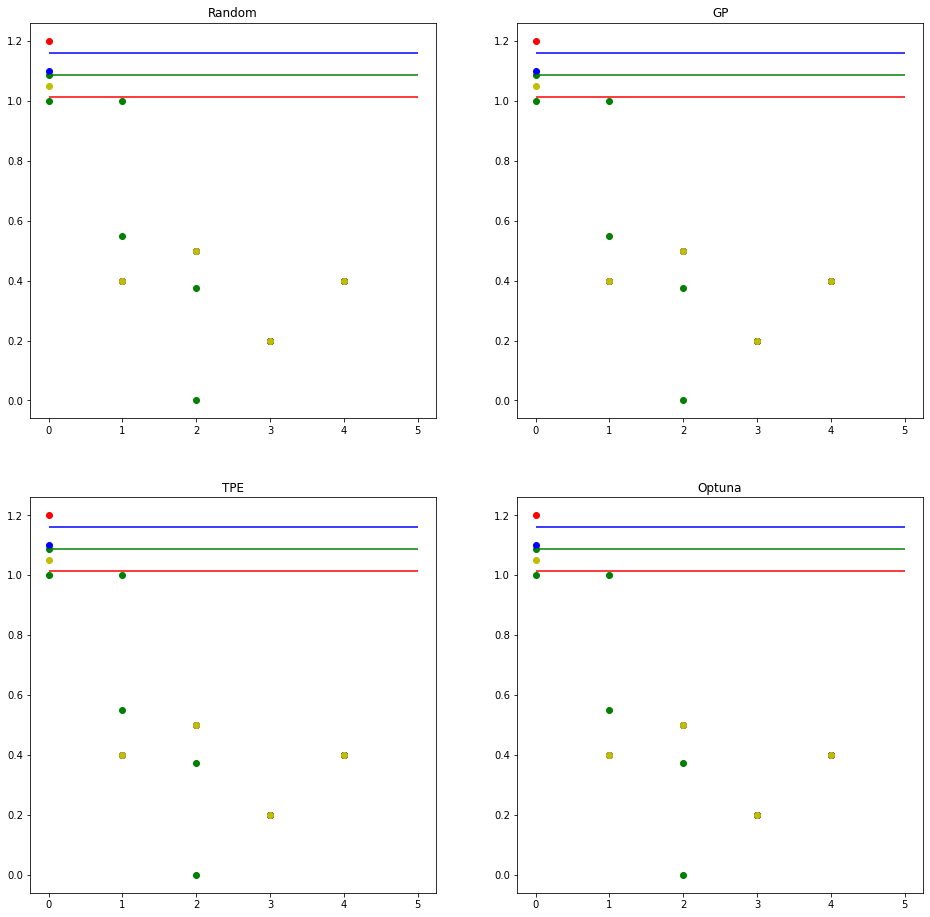

In [40]:
def plot_results(scores: np.ndarray, ax = None, name: str = None) -> None:
    if ax is not None:
        plt.sca(ax)

    avg_score = scores.mean(axis=0)
    avg_best_score = avg_score.max()
    best_scores = scores.max(axis=1)
    plt.scatter(np.arange(avg_score.shape[0]), avg_score, color='g')
    col = ['g', 'r', 'b', 'y']
    for i, one_score in enumerate(scores):
        plt.scatter(np.arange(one_score.shape[0]), one_score, color=col[i % len(col)])

    plt.hlines([
        avg_best_score - np.std(best_scores), avg_best_score, avg_best_score + np.std(best_scores)],
        xmin=0, xmax=avg_score.shape[0], colors=['r', 'g', 'b'])
    if name is not None:
        plt.title(name)

_, axs = plt.subplots(2, 2, figsize=(16, 16))
for i, (name, results) in enumerate(config_results.items()):
    plot_results(np.array(results['score_histories']), axs[i % 2][i // 2], name)

**Задание 2.3 (1.5 балла).** Теперь посмотрим на распределение $p(y|x)$, которое получилось у `GPOptimizer`. Рассмотрим плоскость значений гиперпараметров числа деревьев и learning rate. Настройте ГП на выборку истории значений этих двух гиперпараметров одного из `GPOptimizer`, обученных вами выше. Ядро возьмите такое же, какое использовалось при поиске. Визуализируйте среднее, которое предсказывает ГП на плоскости (вам поможет `plt.imshow` или `plt.scatter`). Также добавьте на рисунок точки из истории поиска. Не забудьте про colorbar'ы и правильные подписи отметок на осях. Сделайте выводы. 

In [92]:
def plot_distribution(sampled, distr, param, name='p(y)', color='b', alpha = .5, label=None):
    plt.scatter(sampled[param], distr, color=color, label=label, alpha=alpha)
    plt.xlabel(param)
    plt.ylabel(name)
    plt.title(f'{name} over {param}')


gp = config_methods['GP']['fitted']
gp.num_samples_per_run = 500
sampled_params = gp.sample_params()
transormed_params, _ = gp.transform_params(gp.params_history)
y_star = np.max(gp.scores_history)
gpr = O.GaussianProcessRegressor(
    kernel=O.kernels.ConstantKernel() + O.kernels.WhiteKernel() + O.kernels.RBF())
gpr.fit(transormed_params, gp.scores_history)
mu, sigma = gpr.predict(gp.transform_params(
    sampled_params)[0], return_std=True)
py = O.norm.cdf(y_star, mu, sigma)
clear_output()

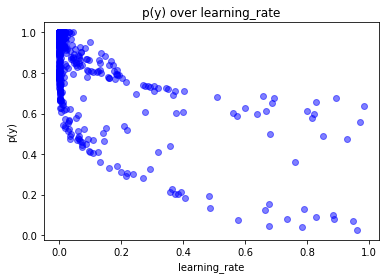

In [93]:
plot_distribution(sampled_params, py, 'learning_rate')

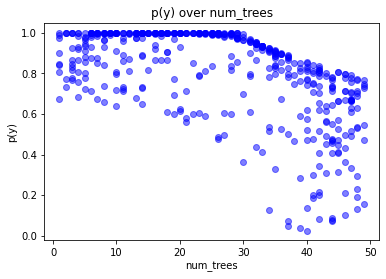

In [94]:
plot_distribution(sampled_params, py, 'num_trees')

**Задание 2.4 (1.5 балла)**. Аналогичным образом визуализируйте значения $\log g(x)$ и $\log l(x)$ на той же плоскости для `TPEOptimizer`. Параметр `bandwidth` оценивайте так же, как и в алгоритме поиска. Не забудьте добавить на рисунок точки из истории поиска (каждую из двух групп поместите на свой график). Что можно сказать о получившихся распределениях?

In [95]:
tpe = config_methods['TPE']['fitted']
tpe.num_samples_per_run = 500
sampled_params = tpe.sample_params()
transormed_params, _ = tpe.transform_params(tpe.params_history)
transormed_sample_params = tpe.transform_params(sampled_params)[0]
bandwidth = np.median(O.NearestNeighbors(n_neighbors=2)
    .fit(transormed_params)
    .kneighbors(transormed_params)[0][:, 1])
quantile = np.quantile(tpe.scores_history, tpe.gamma)

log_pg = tpe.estimate_log_density(
    transormed_params[tpe.scores_history >= quantile], transormed_sample_params, bandwidth)
log_pl = tpe.estimate_log_density(
    transormed_params[tpe.scores_history < quantile], transormed_sample_params, bandwidth)

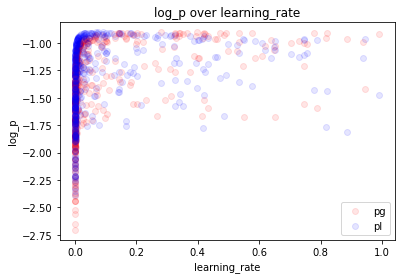

In [96]:
plot_distribution(sampled_params, log_pg, 'learning_rate', 'log_p', 'r', .1, 'pg')
plot_distribution(sampled_params, log_pl, 'learning_rate', 'log_p', 'b', .1, 'pl')
plt.legend()
plt.show()

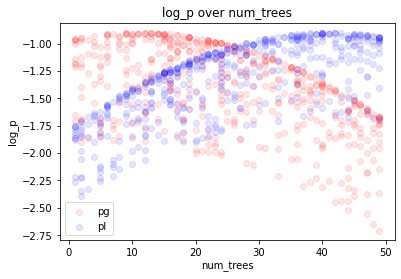

In [97]:
plot_distribution(sampled_params, log_pg, 'num_trees', 'log_p', 'r', .1, 'pg')
plot_distribution(sampled_params, log_pl, 'num_trees', 'log_p', 'b', .1, 'pl')
plt.legend()
plt.show()

**Задание 2.5 (0.5 балла)**. И на последок визуализируем, как изменялись распределения для категориального гиперпараметра у разных стратегий поиска. В этом пункте вам предлагается построить три рисунка:

1. Ддя `GPOptimizer`: постройте графики $\mu(c) \pm \sigma(c)$ для каждой категории $c$ против номера итерации (все на одном рисунке). 


2. Для `TPEOptimizer`: постройте area plot для значений $g(c)$ против номера итерации.


3. Аналогично пункту 2 для значений $l(c)$.

Прокомментируйте то, что получилось.

In [10]:
# Your code here (⊃｡•́‿•̀｡)⊃